# Data Analysis

The New York Times has been an essential American journalistic institution for more than a century, known for its objective reporting and ethical practices. However, recently that long-held credibility has been called into question by none other than the President of the United States (https://twitter.com/realDonaldTrump/status/1098218016255414272). Although a large part of this situation is purely political, it is interesting to think about the balance NYT is trying to maintain between objective reporting, informing the public, serving its local readership, and selling papers.

We are interested in how the New York Times has represented various states in its articles recently and whether we can find any patterns that support or discredit the idea that NYT is representing certain geographic groups of people differently than others.

We began to investigate this question by using the NYT API's "article search" endpoint to acquire a data frame of every piece of work published by NYT in January of 2019, the most recent data available.

**QUANTITATIVE ANALYSES**

In [1]:
#imports
import pandas as pd
import requests
from pandas.io.json import json_normalize
import time

#apikey = 'OOFXXAG7cuVc2q9C0EekCNqWm4lzERfm'

In [2]:
archive = pd.read_csv("archive.csv")

In [3]:
df = pd.DataFrame()
state_list = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
df["state"] = state_list
count_list = []
percent = []
state_counter = 0
total_counter = 0

for state in state_list:
    for headline in archive["headline.main"]:
        if state.lower() in headline.lower():
            state_counter += 1
            total_counter += 1
    count_list.append(state_counter)
    #percent.append(state_counter / len(archive_df_og))
    state_counter = 0
    
df["count"] = count_list
#df["percent"] = percent

In [4]:
df["percent"] = df["count"] / total_counter

In [5]:
df.set_index("state")["count"].sort_values(ascending = False)[:10].plot.bar(
    title = "Number of Mentions in NYT Headlines, January 2019")

This graph shows that New York is state that appears most often in NYT headlines, which makes lots of sense. But there doesn't seem to be much of a pattern with the other common states. 

**Note:** At this point, it was our aspiration to produce a map of relative frequency of mentions for all 50 US states and juxtapose that with a graph of 2016 Presidential Election results. The following code is our attempt at making the first map, but after significant debugging efforts, we could not find the problem. Please skip to the **"Election Data"** header.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

fname = "cb_2017_us_state_5m/cb_2017_us_state_5m"

shp = Reader(fname)

In [7]:
shp_df = pd.DataFrame(
    [record.attributes for record in shp.records()]
)

In [8]:
combined_df = df.merge(shp_df, left_on="state", right_on="NAME", how="right")
combined_df = combined_df[:50]

/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(93, -30) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


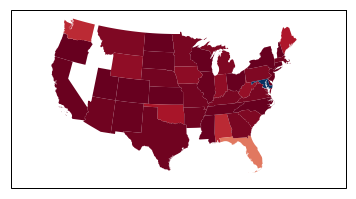

In [9]:
ax = plt.axes(
    projection=ccrs.LambertConformal(
        central_latitude=39,
        central_longitude=-96,
        standard_parallels=(33, 45)
    )
)
ax.set_extent([-125, -66.5, 20, 50])

# define a normalizer and a color map
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=combined_df["percent"].min(), 
                            vmax=combined_df["percent"].max())
cmap = plt.cm.RdBu

# plot the geometries with a facecolor that depends on per_dem
for geometry, (_, row) in zip(shp.geometries(), combined_df.iterrows()):
    if ~pd.isnull(row["percent"]):
        ax.add_geometries([geometry],
                          ccrs.PlateCarree(), #edgecolor = "black",
                          facecolor= cmap(norm(row["percent"])))

**Election Data**

Most of the objection with NYT has been political. The newspaper has often been accused of being left-leaning. If this were the case, we might expect more mentions of states that voted against Donald Trump in the most recent election. 

To see if this is the case, we merged our current data frame with some information about how each state voted in the 2016 election.

In [10]:
election = pd.read_csv("election_bool.csv") #this came from the website:
#"https://www.dailykos.com/stories/2016/11/25/1601042/
#-Nerd-Alert-This-spreadsheet-contains-every-presidential-election-by-state-from-1828-to-2016?"

In [11]:
election = election.iloc[:, 1:]

In [12]:
election.head()

,State,Dem%,Rep%,isDem
0,Alabama,35.6,64.4,False
1,Alaska,41.6,58.4,False
2,Arizona,48.1,51.9,False
3,Arkansas,35.7,64.3,False
4,California,66.1,33.9,True


In [13]:
states = df.merge(election, left_on = "state", right_on = "State", how = "outer")

Of all of the mentions of states in NYT headlines in January, how many were mentions of liberal-voting states?

In [14]:
states.groupby("isDem")["count"].sum() / total_counter

isDem
False    0.317949
True     0.682051
Name: count, dtype: float64

Almost 70%! This seems like potential evidence of something fishy going on at NYT...until we account for the fact that New York was a liberal-voting state. What if take out all of the mentions of New York in headlines and just investigate the distribution of other states?

In [15]:
states.drop(states[states["State"] == "New York"].index, 
            axis = 0).groupby("isDem")["count"].sum() / total_counter

isDem
False    0.317949
True     0.282051
Name: count, dtype: float64

Well, it's a lot more even. In fact, NYT mentioned conservative-voting states even _more!_ That doesn't necessarily mean that the headlines were positive, but neither party here can claim that they weren't represented (expect for those in the 16 states that didn't get a January mention at all).

Another way to analyze the relationship between a state's political affiliation and its being mentioned by the NYT is correlation. In our data, there does exist a positive association between percentage of votes for Hillary Clinton in 2016 and number of mentions in NYT headlines. This relationship remains unchanged when the outlying New York is removed as it was earlier.

In [16]:
states[["count", "Dem%"]].corr()

,count,Dem%
count,1.000000,0.269653
Dem%,0.269653,1.000000


In [17]:
states.drop(states[states["State"] == "New York"].index, axis = 0)[["count", "Dem%"]].corr()

,count,Dem%
count,1.000000,0.272879
Dem%,0.272879,1.000000


**TEXTUAL ANALYSES**

Is there anything more we can learn about this situation with text data? 

_Additional cleaning. Skip to "Common Words" header for results._

In [18]:
head_df = pd.read_csv("state_headlines_for_model.csv")

In [19]:
len(head_df)

500

In [20]:
#a little more cleaning was needed
from collections import Counter

def IsInteger(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

splits_co = head_df[head_df["state"] == "Colorado"]["head_split"].str.split(" ")
splits_wa = head_df[head_df["state"] == "Washington"]["head_split"].str.split(" ")
splits_ny = head_df[head_df["state"] == "New York"]["head_split"].str.split(" ")
splits_ms = head_df[head_df["state"] == "Mississippi"]["head_split"].str.split(" ")
splits_tx = head_df[head_df["state"] == "Texas"]["head_split"].str.split(" ")

In [21]:
all_words_co = []
all_words_wa = []
all_words_ny = []
all_words_ms = []
all_words_tx = []

for i in range(len(splits_co)):
    all_words_co += splits_co[i]
    
for j in range(200, 200+len(splits_wa)):
    all_words_wa += splits_wa[j]
    
for k in range(100, 100+len(splits_ny)):
    all_words_ny += splits_ny[k]
    
for l in range(300, 300+len(splits_ms)):
    all_words_ms += splits_ms[l]
    
for m in range(400, 400+len(splits_tx)):
    all_words_tx += splits_tx[m]

In [22]:
word_bag_co = pd.Series([all_words_co]).apply(Counter)[0]
word_bag_wa = pd.Series([all_words_wa]).apply(Counter)[0]
word_bag_ny = pd.Series([all_words_ny]).apply(Counter)[0]
word_bag_ms = pd.Series([all_words_ms]).apply(Counter)[0]
word_bag_tx = pd.Series([all_words_tx]).apply(Counter)[0]

# remove numbers
word_bag_co_filtered = {key: value for key, value in word_bag_co.items() if IsInteger(key) == False}
word_bag_wa_filtered = {key1: value1 for key1, value1 in word_bag_wa.items() if IsInteger(key1) == False}
word_bag_ny_filtered = {key2: value2 for key2, value2 in word_bag_ny.items() if IsInteger(key2) == False}
word_bag_ms_filtered = {key3: value3 for key3, value3 in word_bag_ms.items() if IsInteger(key3) == False}
word_bag_tx_filtered = {key4: value4 for key4, value4 in word_bag_tx.items() if IsInteger(key4) == False}


stop_words = [ "a", "about", "above", "after", "again", "against",
              "all", "am", "an", "and", "any", "are", "as", "at",
              "be", "because", "been", "before", "being", "below",
              "between", "both", "but", "by", "could", "did", "do",
              "does", "doing", "down", "during", "each", "few", "for",
              "from", "further", "had", "has", "have", "having", "he",
              "he'd", "he'll", "he's", "her", "here", "here's", "hers",
              "herself", "him", "himself", "his", "how", "how's", "i",
              "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is",
              "it", "it's", "its", "itself", "let's", "me", "more",
              "most", "my", "myself", "negro", "negroes", "nor", "of", "on", "once",
              "only", "or", "other", "ought", "our", "ours", "ourselves",
              "out", "over", "own", "same", "she", "she'd", "she'll",
              "she's", "should", "so", "some", "such", "than", "that",
              "that's", "the", "their", "theirs", "them", "themselves",
              "then", "there", "there's", "these", "they", "they'd",
              "they'll", "they're", "they've", "this", "those", "through",
              "to", "too", "under", "until", "up", "very", "was", "we",
              "we'd", "we'll", "we're", "we've", "were", "what", "what's",
              "when", "when's", "where", "where's", "which", "while", "who",
              "who's", "whom", "why", "why's", "with", "would", "you", "you'd",
              "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [23]:
word_bag_co_filtered = {key: value for key, value in word_bag_co_filtered.items() if key not in stop_words}
word_bag_wa_filtered = {key1: value1 for key1, value1 in word_bag_wa_filtered.items() if key1 not in stop_words}
word_bag_ny_filtered = {key2: value2 for key2, value2 in word_bag_ny_filtered.items() if key2 not in stop_words}
word_bag_ms_filtered = {key3: value3 for key3, value3 in word_bag_ms_filtered.items() if key3 not in stop_words}
word_bag_tx_filtered = {key4: value4 for key4, value4 in word_bag_tx_filtered.items() if key4 not in stop_words}

freqs_co = pd.Series(word_bag_co_filtered)[pd.Series(word_bag_co_filtered) > 1]
freqs_wa = pd.Series(word_bag_wa_filtered)[pd.Series(word_bag_wa_filtered) > 1]
freqs_ny = pd.Series(word_bag_ny_filtered)[pd.Series(word_bag_ny_filtered) > 1]
freqs_ms = pd.Series(word_bag_ms_filtered)[pd.Series(word_bag_ms_filtered) > 1]
freqs_tx = pd.Series(word_bag_tx_filtered)[pd.Series(word_bag_tx_filtered) > 1]

**Common Words**

We looked at the 100 most recent headlines containing the name of each of our five states of interest and looked at the distribution of their most common words (aside from the actual state name, which was always the single most common word, so we did not include it in the visual).

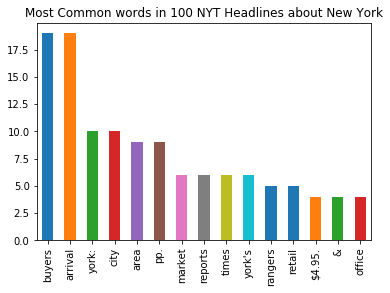

In [24]:
freqs_ny.sort_values(ascending=False)[2:17].plot.bar(
    title="Most Common words in 100 NYT Headlines about New York")

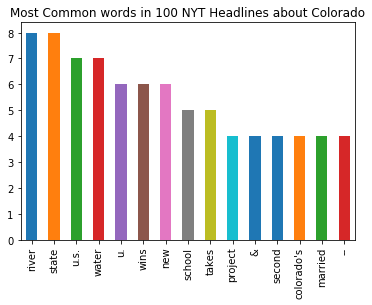

In [25]:
freqs_co.sort_values(ascending=False)[1:16].plot.bar(
    title="Most Common words in 100 NYT Headlines about Colorado")

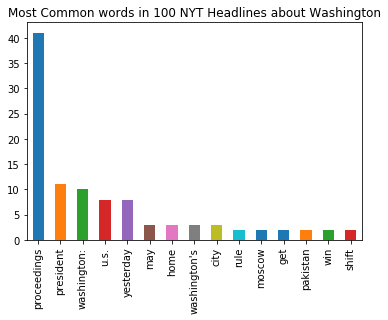

In [26]:
freqs_wa.sort_values(ascending=False)[1:16].plot.bar(
    title="Most Common words in 100 NYT Headlines about Washington")

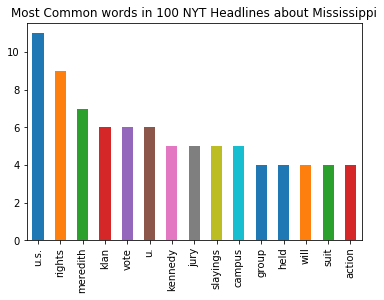

In [27]:
freqs_ms.sort_values(ascending=False)[1:16].plot.bar(
    title="Most Common words in 100 NYT Headlines about Mississippi")

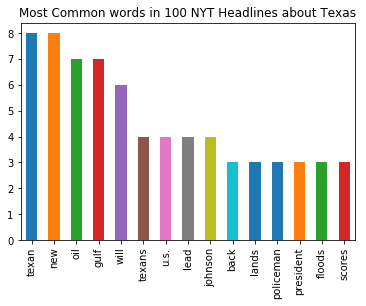

In [28]:
freqs_tx.sort_values(ascending=False)[1:16].plot.bar(
    title="Most Common words in 100 NYT Headlines about Texas")

These graphs do show some differences. New York's headlines seem to feature financial terms like "buyers", "market", and "retail" which makes sense considering NYC is the economic center of the US. Colorado's words seem to describe a much smaller-scale state, mentioning water, river, and school. Washington, which we later realized includes headlines about Washington D.C. as well, obviously centers around politics with common words like "preceedings" and "president". Mississippi, known for being predominantly conservative, had words like "klan" and "slayings", which aren't exactly flattering. Texas, also known to be conservative, has words about its industries but that aren't necessarily positive. These trends appear to faintly support the claim that NYT writes more favorably about left-voting states.

**Generating Headlines with Markov Chains**

To evaluate this effect in a different way, we trained Markov chains on the last 100 NYT headlines mentioning each of five US states (New York, Colorado, Washington, Mississippi, and Texas) to generate headlines that may have been written about each state. We'll see if there are any patterns in how headlines about each of these states differ for better or worse.

(**Note:** we originally used a bigram Markov Chain, but with only 100 headlines to train on, the generation of new headlines just resulted in duplicates of fully in-tact headlines, so we opted for a unigram function instead.)

In [29]:
head_df["headline_raw"] = head_df["headline.main"].str.lower().replace(
    "[^A-Za-z\s]", "").str.replace(";", "").replace(",", "")

head_df["head_split"] = head_df["headline_raw"].str.split(",").str.join("")

In [30]:
def train_markov_chain(lyrics):
    chain = {"<START>": []}
    for lyric in lyrics:
        i = 0
        lyric_new = lyric.split(" ")
        lyric_split = [word for word in lyric_new if len(word) > 0 and word != ' ']
        chain["<START>"].append(lyric_split[0])
        for i in range(len(lyric_split)):
            if lyric_split[i] not in chain.keys():
                if i + 1 == len(lyric_split):
                    chain[lyric_split[i]] = ["<END>"]
                    break
                else:
                    chain[lyric_split[i]] = [lyric_split[i + 1]]
            else:
                if i == len(lyric_split) - 1:
                    chain[lyric_split[i]] = ["<END>"]
                    break
                else:
                    #print(i, len(lyric))
                    chain[lyric_split[i]].append(lyric_split[i + 1])
        
    return chain

In [31]:
headline_list_co = list(head_df[head_df["state"] == "Colorado"]["head_split"])
head_chain_co = train_markov_chain(headline_list_co)

headline_list_wa = list(head_df[head_df["state"] == "Washington"]["head_split"])
head_chain_wa = train_markov_chain(headline_list_wa)

headline_list_ny = list(head_df[head_df["state"] == "New York"]["head_split"])
head_chain_ny = train_markov_chain(headline_list_ny)

headline_list_ms = list(head_df[head_df["state"] == "Mississippi"]["head_split"])
head_chain_ms = train_markov_chain(headline_list_ms)

headline_list_tx = list(head_df[head_df["state"] == "Texas"]["head_split"])
head_chain_tx = train_markov_chain(headline_list_tx)

In [32]:
import random

def generate_new_headline(chain):
    words = []
    # generate the first word
    words.append(random.choice(chain["<START>"]))
    word = words[0]
    while word != '<END>':
        new_word = random.choice(chain[word])
        words.append(new_word)
        if new_word == '<END>':
            break
        while len(chain[new_word]) == 0:
            print("empty list to choose from")
            print(new_word)
            new_word = random.choice(chain[new_word])
        
        else:
            word = new_word
    
    
    # join the words together into a string with line breaks
    lyrics = " ".join(words[:-1])
    return "\n".join(lyrics.split("<N>"))

**Randomly Generating 5 New Headlines for Each State**

In [33]:

print("5 NEW YORK HEADLINES: \n")
for i in range(5):
    print("-", generate_new_headline(head_chain_ny))

5 NEW YORK HEADLINES: 

- fans swell jersey coffers
- treasury statement
- the new court league signs player is future bride affianced to new york: coward-mccann. $3.95.
- arrival of the arrival of buyers in fence-off at yonkers ignoring city rebekah harkness foundation dance at the new york since 1962 opener
- bank of buyers in the new york


In [38]:
print("5 COLORADO HEADLINES: \n")
for i in range(5):
    print("-", generate_new_headline(head_chain_co))

5 COLORADO HEADLINES: 

- marriage held tuesday
- flood spreads in colorado river water
- soviet six on aug. 27
- senator asks state study of colorado joins olympic bidders governor meets with agnew
- colorado governor makes a sea of power and marielle goitschel of the carrier --el paso must leave state


In [35]:
print("5 WASHINGTON HEADLINES: \n")
for i in range(5):
    print("-", generate_new_headline(head_chain_wa))

5 WASHINGTON HEADLINES: 

- washington: the bureaucratic curtain
- washington
- washington poor to tokyo
- washington considered for today crimson choice to return okinawa to bring washington poor to tokyo
- the proceedings


In [36]:
print("5 MISSISSIPPI HEADLINES: \n")
for i in range(5):
    print("-", generate_new_headline(head_chain_ms))

5 MISSISSIPPI HEADLINES: 

- weyerhaeuser acquires a civil rights 'invasion'
- foot forward in mississippi accuses rival of manslaughter
- violence in mississippi mob
- foot forward in 3 rights slayings
- student group denounces campus editor


In [46]:
print("5 TEXAS HEADLINES: \n")
for i in range(5):
    print("-", generate_new_headline(head_chain_tx))

5 TEXAS HEADLINES: 

- commission lifts oil
- filtrol is plush
- texans and commercial building gain texas winner due in texas flood control area struck by c.b.s.
- texas eastern to prison on sales tax
- an explosion at texas president


Just by looking at these randomly generated headlines, it's hard to parse whether there are significant differences between the words used in the headlines about these five states. In the next notebook, we'll build a K-Nearest Neighbors model that will attempt to predict which state the headline was written about given the headline text.